# CNN Image Classification Laboration


Images used in this laboration are from CIFAR 10 (https://en.wikipedia.org/wiki/CIFAR-10). The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Your task is to make a classifier, using a convolutional neural network, that can correctly classify each image into the correct class.

You need to answer all questions in this notebook. 

## Part 1: What is a convolution

To understand a bit more about convolutions, we will first test the convolution function in scipy using a number of classical filters. 

Convolve the image with Gaussian filter, a Sobel X filter, and a Sobel Y filter, using the function 'convolve2d' in 'signal' from scipy.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

In a CNN, many filters are applied in each layer, and the filter coefficients are learned through back propagation (which is in contrast to traditional image processing, where the filters are designed by an expert).

In [3]:
# This cell is finished

from scipy import signal
import numpy as np

# Get a test image
from scipy import misc
image = misc.ascent()

# Define a help function for creating a Gaussian filter
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# Create Gaussian filter with certain size and standard deviation
gaussFilter = matlab_style_gauss2D((15,15),4)

# Define filter kernels for SobelX and Sobely
sobelX = np.array([[ 1, 0,  -1],
                    [2, 0, -2],
                    [1, 0, -1]]) 

sobelY = np.array([[ 1, 2,  1],
                    [0, 0, 0],
                    [-1, -2, -1]]) 

In [4]:
# Perform convolution using the function 'convolve2d' for the different filters
filterResponseGauss = signal.convolve2d(image,gaussFilter)
filterResponseSobelX = signal.convolve2d(image,sobelX)
filterResponseSobelY = signal.convolve2d(image,sobelY)

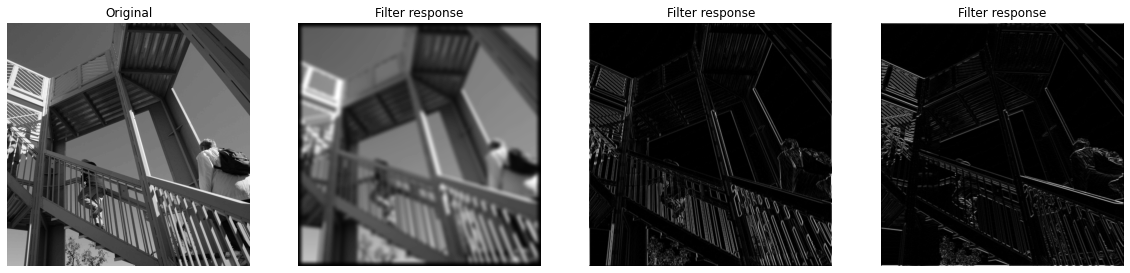

In [5]:
import matplotlib.pyplot as plt

# Show filter responses
fig, (ax_orig, ax_filt1, ax_filt2, ax_filt3) = plt.subplots(1, 4, figsize=(20, 6))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_filt1.imshow(np.absolute(filterResponseGauss), cmap='gray')
ax_filt1.set_title('Filter response')
ax_filt1.set_axis_off()
ax_filt2.imshow(np.absolute(filterResponseSobelX), cmap='gray')
ax_filt2.set_title('Filter response')
ax_filt2.set_axis_off()
ax_filt3.imshow(np.absolute(filterResponseSobelY), cmap='gray')
ax_filt3.set_title('Filter response')
ax_filt3.set_axis_off()

##  Part 2: Understanding convolutions

Question 1: What do the 3 different filters (Gaussian, SobelX, SobelY) do to the original image?

1. Doing convolution scalar product between filter coefficients and pixels in each neighborhood.

Question 2: What is the size of the original image? How many channels does it have? How many channels does a color image normally have?

2. The size of the original image is 512*512. A color image normally has 3 channels, red, blud and yellow.

Question 3: What is the size of the different filters?

3. The size of gussian filters is 15 * 15, while the size of the other two is 3*3

Question 4: What is the size of the filter response if mode 'same' is used for the convolution ?

4. The response of the filter is the same size as original image, if 'same' mode is used.

Question 5: What is the size of the filter response if mode 'valid' is used for the convolution? How does the size of the valid filter response depend on the size of the filter? 

5. If the mode 'valid' is set in convolution2d, those pixels filled with zeros would be ignored from filter response. The size of valid reponse is the size of original image minus the size of filter.

Question 6: Why are 'valid' convolutions a problem for CNNs with many layers?

6. the image size would be samller and smaller as signal go through network.


In [6]:
# Your code for checking sizes of image and filter responses
filterResponseGauss = signal.convolve2d(image,gaussFilter,mode='valid')
filterResponseSobelX = signal.convolve2d(image,sobelX,mode='valid')
filterResponseSobelY = signal.convolve2d(image,sobelY,mode='valid')
image.shape



(512, 512)

##  Part 3: Get a graphics card

Skip this part if you run on a CPU

Let's make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming convolutions in every training iteration.

In [7]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

##  Part 4: How fast is the graphics card?

Question 7: Why are the filters of size 7 x 7 x 3, and not 7 x 7 ? 

7. The image usually has three channels, therefore the filter has the depth 3.

Question 8: What operation is performed by the 'Conv2D' layer? Is it a standard 2D convolution, as performed by the function signal.convolve2d we just tested?

8. 'Conv2D' can process convolutional compution with several channels to the input data, while the convolve2d can only process single channel.

Lets investigate how much faster a convolution is with the graphics card (skip this part if you run on a CPU)

Question 9: How much faster is the graphics card, compared to the CPU, for convolving a batch of 100 images?

9. GPU is 68 times faster than CPU at this step.

Question 10: How much faster is the graphics card, compared to the CPU, for convolving a batch of 2 images? Explain the difference compared to 100 images.

10. GPU is only 2 times faster this time as the there is less performance difference between CPU and GPU in samll dataset.

In [8]:
# Run this cell to compare processing time of CPU and GPU

import timeit

n_images_in_batch = 2

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# Perform convolutions using the CPU
def cpu():
  with tf.device('/cpu:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_cpu)

# Perform convolutions using the GPU (graphics card)
def gpu():
  with tf.device('/device:GPU:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the convolution several times and measure the time
print('Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3'
      ' (batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3 (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.08863688699997851
GPU (s):
0.03427567699998235
GPU speedup over CPU: 2x


##  Part 5:  Load data
Time to make a 2D CNN. Load the images and labels from keras.datasets, this cell is already finished.

In [9]:
from keras.datasets import cifar10
import numpy as np

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Download CIFAR train and test data
(Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data()

print("Training images have size {} and labels have size {} ".format(Xtrain.shape, Ytrain.shape))
print("Test images have size {} and labels have size {} \n ".format(Xtest.shape, Ytest.shape))

# Reduce the number of images for training and testing to 10000 and 2000 respectively, 
# to reduce processing time for this laboration
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

Xtest = Xtest[0:2000]
Ytest = Ytest[0:2000]

Ytestint = Ytest

print("Reduced training images have size %s and labels have size %s " % (Xtrain.shape, Ytrain.shape))
print("Reduced test images have size %s and labels have size %s \n" % (Xtest.shape, Ytest.shape))

# Check that we have some training examples from each class
for i in range(10):
    print("Number of training examples for class {} is {}" .format(i,np.sum(Ytrain == i)))

170500096/170498071 [==============================] - 4s 0us/step
Training images have size (50000, 32, 32, 3) and labels have size (50000, 1) 
Test images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
 
Reduced training images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
Reduced test images have size (2000, 32, 32, 3) and labels have size (2000, 1) 

Number of training examples for class 0 is 1005
Number of training examples for class 1 is 974
Number of training examples for class 2 is 1032
Number of training examples for class 3 is 1016
Number of training examples for class 4 is 999
Number of training examples for class 5 is 937
Number of training examples for class 6 is 1030
Number of training examples for class 7 is 1001
Number of training examples for class 8 is 1025
Number of training examples for class 9 is 981


##  Part 6: Plotting

Lets look at some of the training examples, this cell is already finished. You will see different examples every time you run the cell.

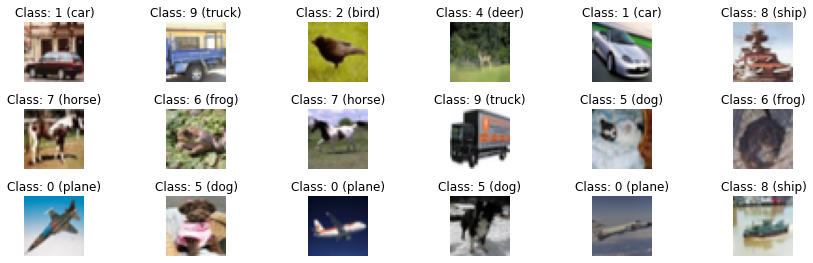

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(18):
    idx = np.random.randint(7500)
    label = Ytrain[idx,0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(Xtrain[idx])
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

##   Part 7: Split data into training, validation and testing
Split your training data into training (Xtrain, Ytrain) and validation (Xval, Yval), so that we have training, validation and test datasets (as in the previous laboration). We use a function in scikit learn. Use 25% of the data for validation.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [11]:
from sklearn.model_selection import train_test_split

Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.25, random_state=42)

# Print the size of training data, validation data and test data
print('The size of training data is ',Xtrain.shape[0])
print('The size of validation data is ',Xval.shape[0])

The size of training data is  7500
The size of validation data is  2500


##  Part 8: Preprocessing of images

Lets perform some preprocessing. The images are stored as uint8, i.e. 8 bit unsigned integers, but need to be converted to 32 bit floats. We also make sure that the range is -1 to 1, instead of 0 - 255. This cell is already finished.

In [12]:
# Convert datatype for Xtrain, Xval, Xtest, to float32
Xtrain = Xtrain.astype('float32')
Xval = Xval.astype('float32')
Xtest = Xtest.astype('float32')

# Change range of pixel values to [-1,1]
Xtrain = Xtrain / 127.5 - 1
Xval = Xval / 127.5 - 1
Xtest = Xtest / 127.5 - 1

##  Part 9: Preprocessing of labels

The labels (Y) need to be converted from e.g. '4' to "hot encoded", i.e. to a vector of type [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] . We use a function in Keras, see https://keras.io/api/utils/python_utils/#to_categorical-function

In [13]:
from keras.utils import to_categorical

# Print shapes before converting the labels

print('The shape of Ytrain: ',Ytrain.shape)
print('The shape of Yval: ',Yval.shape)
print('The shape of Ytest: ',Ytest.shape)

# Your code for converting Ytrain, Yval, Ytest to categorical

Ytrain = to_categorical(Ytrain, num_classes=None, dtype="int")
Yval = to_categorical(Yval, num_classes=None, dtype="int")
Ytest = to_categorical(Ytest, num_classes=None, dtype="int")

# Print shapes after converting the labels
print('\n','The shapes after converting is following')
print('The shape of Ytrain: ',Ytrain.shape)
print('The shape of Yval: ',Yval.shape)
print('The shape of Ytest: ',Ytest.shape)


The shape of Ytrain:  (7500, 1)
The shape of Yval:  (2500, 1)
The shape of Ytest:  (2000, 1)

 The shapes after converting is following
The shape of Ytrain:  (7500, 10)
The shape of Yval:  (2500, 10)
The shape of Ytest:  (2000, 10)


##  Part 10: 2D CNN
Finish this code to create the image classifier, using a 2D CNN. Each convolutional layer will contain 2D convolution, batch normalization and max pooling. After the convolutional layers comes a flatten layer and a number of intermediate dense layers. The convolutional layers should take the number of filters as an argument, use a kernel size of 3 x 3, 'same' padding, and relu activation functions. The number of filters will double with each convolutional layer. The max pooling layers should have a pool size of 2 x 2. The intermediate dense layers before the final dense layer should take the number of nodes as an argument, use relu activation functions, and be followed by batch normalization. The final dense layer should have 10 nodes (= the number of classes in this laboration) and 'softmax' activation. Here we start with the Adam optimizer.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`Conv2D()`, performs 2D convolutions with a number of filters with a certain size (e.g. 3 x 3). 

`BatchNormalization()`, perform batch normalization

`MaxPooling2D()`, saves the max for a given pool size, results in down sampling

`Flatten()`, flatten a multi-channel tensor into a long vector

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/api/layers/core_layers/dense/ and https://keras.io/api/layers/reshaping_layers/flatten/ for information on how the `Dense()` and `Flatten()` functions work

See https://keras.io/layers/convolutional/ for information on how `Conv2D()` works

See https://keras.io/layers/pooling/ for information on how `MaxPooling2D()` works

Import a relevant cost function for multi-class classification from keras.losses (https://keras.io/losses/)

See the following links for how to compile, train and evaluate the model

https://keras.io/api/models/model_training_apis/#compile-method

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

In [14]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

from tensorflow.keras import activations
# model.add(layers.Activation(activations.relu))


# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01):

    # Setup a sequential model
    model = Sequential()

    # Add first convolutional layer to the model, requires input shape
    model.add(Conv2D(n_filters,3,padding = 'same',input_shape=input_shape[1:],activation='relu'))
    model.add(BatchNormalization())


    #Add dropout
    if use_dropout == True:
      model.add(Dropout(0.2))

    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),padding='valid'))
    # Add remaining convolutional layers to the model, the number of filters should increase a factor 2 for each layer

    for i in range(n_conv_layers-1):
      model.add(Conv2D(n_filters*(2**(i+1)),3,activation='relu',padding = 'same'))
      model.add(BatchNormalization())

      #Add dropout
      if use_dropout == True:
        model.add(Dropout(0.3))

      model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),padding='valid'))

    # Add flatten layer
    model.add(Flatten())

    # Add intermediate dense layers
    for i in range(n_dense_layers):
        model.add(Dense(n_nodes,activation='relu'))
        model.add(BatchNormalization())

      #Add dropout
        if use_dropout == True:
          model.add(Dropout(0.3))        

    # Add final dense layer
    model.add(Dense(10,activation='softmax'))

    # Compile model
    optim = Adam(lr=learning_rate)
    model.compile(optimizer=optim,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [15]:
# Lets define a help function for plotting the training results
import matplotlib.pyplot as plt
def plot_results(history):
    
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

## Part 11: Train 2D CNN

Time to train the 2D CNN, start with 2 convolutional layers, no intermediate dense layers, learning rate = 0.01. The first convolutional layer should have 16 filters (which means that the second convolutional layer will have 32 filters).

Relevant functions

`build_CNN`, the function we defined in Part 10, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

See the following links for how to train and evaluate the model

https://keras.io/api/models/model_training_apis/#fit-method

https://keras.io/api/models/model_training_apis/#evaluate-method

## 2 convolutional layers, no intermediate dense layers

In [16]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape

# Build model
model1 = build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01)

# Train the model  using training data and validation data
history1 = model1.fit(
                        x=Xtrain,
                        y=Ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xval,Yval))
model1.summary()

Epoch 1/20
75/75 [==============================] - 2s 9ms/step - loss: 3.7602 - accuracy: 0.2764 - val_loss: 1.7971 - val_accuracy: 0.3624
Epoch 2/20
75/75 [==============================] - 0s 5ms/step - loss: 1.7144 - accuracy: 0.4609 - val_loss: 1.7747 - val_accuracy: 0.3776
Epoch 3/20
75/75 [==============================] - 0s 4ms/step - loss: 1.2428 - accuracy: 0.5619 - val_loss: 1.6292 - val_accuracy: 0.4192
Epoch 4/20
75/75 [==============================] - 0s 4ms/step - loss: 1.0504 - accuracy: 0.6306 - val_loss: 1.5435 - val_accuracy: 0.4504
Epoch 5/20
75/75 [==============================] - 0s 5ms/step - loss: 0.9396 - accuracy: 0.6744 - val_loss: 1.3164 - val_accuracy: 0.5552
Epoch 6/20
75/75 [==============================] - 0s 5ms/step - loss: 0.8298 - accuracy: 0.7150 - val_loss: 1.3211 - val_accuracy: 0.5524
Epoch 7/20
75/75 [==============================] - 0s 4ms/step - loss: 0.7370 - accuracy: 0.7414 - val_loss: 1.4393 - val_accuracy: 0.5524
Epoch 8/20
75/75 [==

In [17]:
# Evaluate the trained model on test set, not used in training or validation
score = model1.evaluate(Xtest, Ytest, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 2.6072
Test accuracy: 0.5560


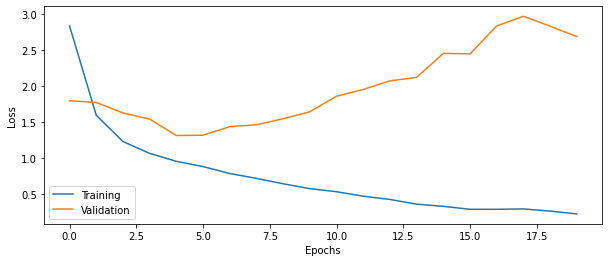

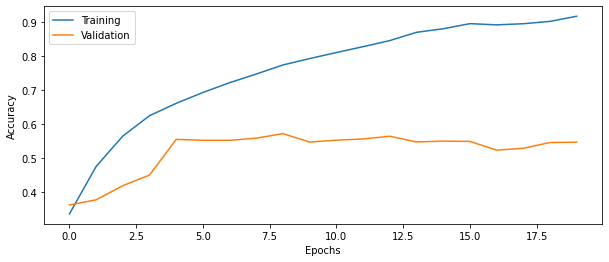

In [18]:
# Plot the history from the training run
plot_results(history1)

## Part 12: Improving performance

Skip question 12 if you run on a CPU

Write down the test accuracy, are you satisfied with the classifier performance (random chance is 10%) ? 

Question 11: How big is the difference between training and test accuracy?

11. Training accuracy is more than 40% higher than test accuracy.

Question 12: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'watch nvidia-smi' on the cloud computer during training. 

12. GPU utility peaks at 46% in training as batch size is 100, and 787MiB memory is used.

Question 13: For the DNN laboration we used a batch size of 10,000, why do we need to use a smaller batch size in this laboration?

13. This is because that the image data is larger than the data in lab1.

## 2 convolutional layers, 1 intermediate dense layer (50 nodes)

In [24]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape

# Build model
model2 = build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=1, n_nodes=50, use_dropout=False, learning_rate=0.01)

# Train the model  using training data and validation data
history2 = model2.fit(
                        x=Xtrain,
                        y=Ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xval,Yval))

model2.summary()

Epoch 1/20
75/75 [==============================] - 1s 8ms/step - loss: 1.9686 - accuracy: 0.3287 - val_loss: 1.7196 - val_accuracy: 0.3856
Epoch 2/20
75/75 [==============================] - 0s 5ms/step - loss: 1.2719 - accuracy: 0.5444 - val_loss: 1.9349 - val_accuracy: 0.3544
Epoch 3/20
75/75 [==============================] - 0s 5ms/step - loss: 1.0441 - accuracy: 0.6265 - val_loss: 1.6177 - val_accuracy: 0.4436
Epoch 4/20
75/75 [==============================] - 0s 5ms/step - loss: 0.8565 - accuracy: 0.7030 - val_loss: 1.3774 - val_accuracy: 0.5300
Epoch 5/20
75/75 [==============================] - 0s 5ms/step - loss: 0.6638 - accuracy: 0.7686 - val_loss: 1.6654 - val_accuracy: 0.5320
Epoch 6/20
75/75 [==============================] - 0s 5ms/step - loss: 0.5228 - accuracy: 0.8182 - val_loss: 1.6614 - val_accuracy: 0.5564
Epoch 7/20
75/75 [==============================] - 0s 5ms/step - loss: 0.3690 - accuracy: 0.8784 - val_loss: 2.0653 - val_accuracy: 0.5304
Epoch 8/20
75/75 [==

In [86]:
# Evaluate the trained model on test set, not used in training or validation
score = model2.evaluate(Xtest, Ytest, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 3.2496
Test accuracy: 0.5535


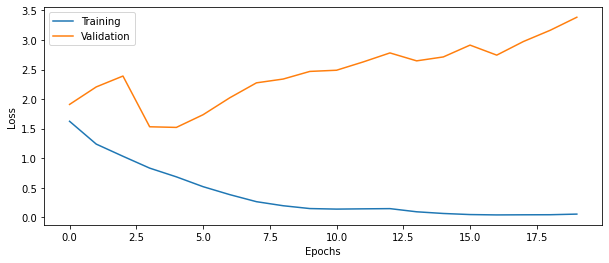

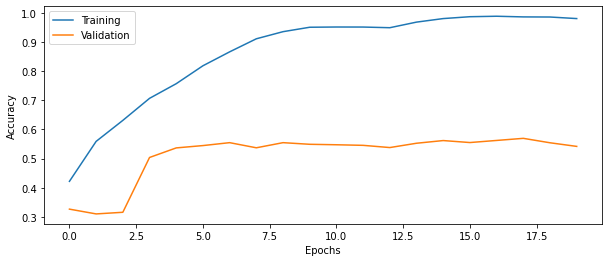

In [87]:
# Plot the history from the training run
plot_results(history2)

## 4 convolutional layers, 1 intermediate dense layer (50 nodes)

In [20]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = Xtrain.shape

# Build model
model3 = build_CNN(input_shape, n_conv_layers=4, n_filters=16, n_dense_layers=1, n_nodes=50, use_dropout=False, learning_rate=0.01)

# Train the model  using training data and validation data
history3 = model3.fit(
                        x=Xtrain,
                        y=Ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xval,Yval))

model3.summary()

Epoch 1/20
75/75 [==============================] - 2s 9ms/step - loss: 1.9837 - accuracy: 0.3076 - val_loss: 2.4318 - val_accuracy: 0.2392
Epoch 2/20
75/75 [==============================] - 0s 6ms/step - loss: 1.3895 - accuracy: 0.4912 - val_loss: 2.1319 - val_accuracy: 0.2892
Epoch 3/20
75/75 [==============================] - 0s 6ms/step - loss: 1.1608 - accuracy: 0.5787 - val_loss: 1.5997 - val_accuracy: 0.4684
Epoch 4/20
75/75 [==============================] - 0s 6ms/step - loss: 0.9794 - accuracy: 0.6474 - val_loss: 1.8967 - val_accuracy: 0.4596
Epoch 5/20
75/75 [==============================] - 0s 6ms/step - loss: 0.8358 - accuracy: 0.7027 - val_loss: 1.5396 - val_accuracy: 0.5600
Epoch 6/20
75/75 [==============================] - 0s 6ms/step - loss: 0.6580 - accuracy: 0.7672 - val_loss: 1.5283 - val_accuracy: 0.5804
Epoch 7/20
75/75 [==============================] - 0s 6ms/step - loss: 0.5445 - accuracy: 0.8078 - val_loss: 1.8590 - val_accuracy: 0.5660
Epoch 8/20
75/75 [==

In [21]:
# Evaluate the trained model on test set, not used in training or validation
score = model3.evaluate(Xtest, Ytest, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 2.6901
Test accuracy: 0.5785


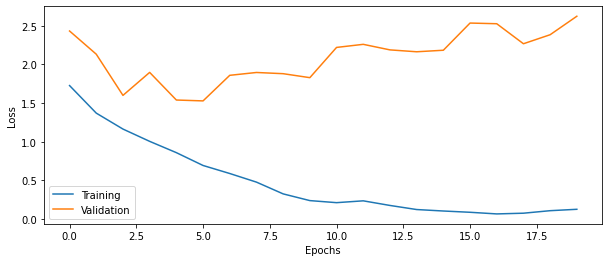

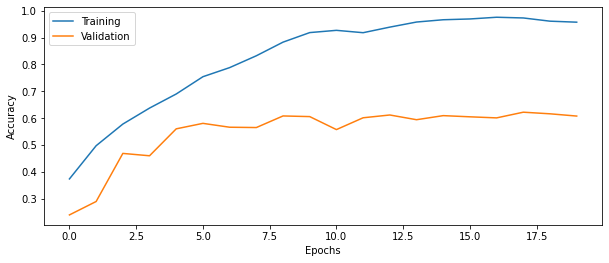

In [22]:
# Plot the history from the training run
plot_results(history3)

##  Part 13: Plot the CNN architecture

To understand your network better, print the architecture using `model.summary()`

Question 14: How many trainable parameters does your network have? Which part of the network contains most of the parameters?

14. There are 124180 trainable parameters in the network, and the fourth convolutional layer and dense layer have most part of parameters.

Question 15: What is the input to and output of a Conv2D layer? What are the dimensions of the input and output? 

15. The input of a Con2D layer is data from last layer, with the data fromat is wide*height*channels. The output is the convolutional result of this layer.

Question 16: Is the batch size always the first dimension of each 4D tensor? Check the documentation for Conv2D, https://keras.io/layers/convolutional/

16. Yes

Question 17: If a convolutional layer that contains 128 filters is applied to an input with 32 channels, what is the number of channels in the output?

17. 128 channels

Question 18: Why is the number of parameters in each Conv2D layer *not* equal to the number of filters times the number of filter coefficients per filter (plus biases)?

18. This is because there are different data in each channels.

Question 19: How does MaxPooling help in reducing the number of parameters to train?

19. It only picks up part of the pixels or voxels of the input data as output.

In [23]:
# Print network architecture

model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 8, 8, 64)         

##  Part 14: Dropout regularization

Add dropout regularization to each intermediate dense layer, dropout probability 50%.

Question 20: How much did the test accuracy improve with dropout, compared to without dropout?

20. Compared with the network without dropout, accuracy of the one with dropout layers improves about 3%, very little, but the overfitting have been reduced significantly.

Question 21: What other types of regularization can be applied? How can you add L2 regularization for the convolutional layers?

21.  L1, L2, L1+L2 regularization, and other indirect regularization. L2 regulerization should be added in parameter updating, as the L2 control the shrinkage of parameters here, adding one penalty item in updating.


## 4 convolutional layers, 1 intermediate dense layer (50 nodes), dropout

In [24]:
# Setup some training parameters
batch_size = 80
epochs = 20
input_shape = Xtrain.shape

# Build model
model4 = build_CNN(input_shape, n_conv_layers=4, n_filters=16, n_dense_layers=1, n_nodes=50, use_dropout=True, learning_rate=0.01)

# Train the model  using training data and validation data
history4 = model4.fit(
                        x=Xtrain,
                        y=Ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xval,Yval))

model4.summary()


Epoch 1/20
94/94 [==============================] - 2s 9ms/step - loss: 2.1952 - accuracy: 0.2458 - val_loss: 1.9899 - val_accuracy: 0.3156
Epoch 2/20
94/94 [==============================] - 1s 6ms/step - loss: 1.6388 - accuracy: 0.3979 - val_loss: 2.2381 - val_accuracy: 0.3316
Epoch 3/20
94/94 [==============================] - 1s 7ms/step - loss: 1.5020 - accuracy: 0.4482 - val_loss: 1.8163 - val_accuracy: 0.4004
Epoch 4/20
94/94 [==============================] - 1s 6ms/step - loss: 1.3398 - accuracy: 0.5030 - val_loss: 1.4983 - val_accuracy: 0.4792
Epoch 5/20
94/94 [==============================] - 1s 6ms/step - loss: 1.2654 - accuracy: 0.5435 - val_loss: 1.4386 - val_accuracy: 0.4988
Epoch 6/20
94/94 [==============================] - 1s 6ms/step - loss: 1.1918 - accuracy: 0.5766 - val_loss: 1.3737 - val_accuracy: 0.5336
Epoch 7/20
94/94 [==============================] - 1s 6ms/step - loss: 1.0901 - accuracy: 0.6074 - val_loss: 1.2889 - val_accuracy: 0.5424
Epoch 8/20
94/94 [==

In [25]:
# Evaluate the trained model on test set, not used in training or validation
score = model4.evaluate(Xtest, Ytest, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 1.3220
Test accuracy: 0.5880


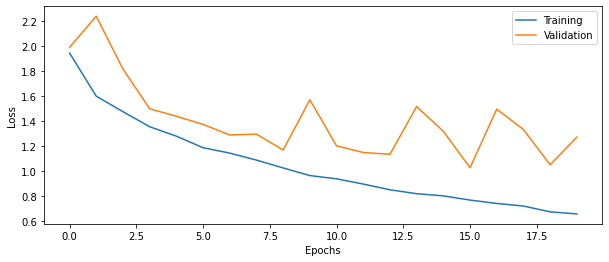

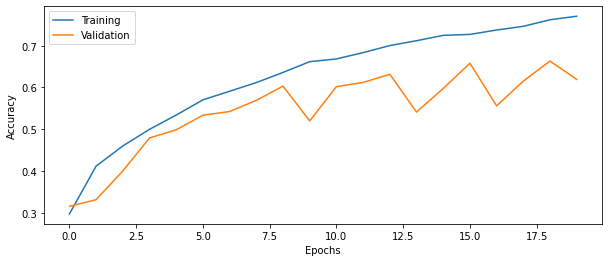

In [26]:
# Plot the history from the training run
plot_results(history4)

##  Part 15: Tweaking performance

You have now seen the basic building blocks of a 2D CNN. To further improve performance involves changing the number of convolutional layers, the number of filters per layer, the number of intermediate dense layers, the number of nodes in the intermediate dense layers, batch size, learning rate, number of epochs, etc. Spend some time (30 - 90 minutes) testing different settings.

Question 22: How high test accuracy can you obtain? What is your best configuration?

22. 66% of accuracy on test set. 
best configuration: 
batch size = 50
epochs = 40
number of convolution layers = 3
number of filters = 25
number of dense intermediate layers = 1
number of nodes = 64
learning rate = 0.005


## Your best config

In [56]:
# Setup some training parameters
batch_size = 80
epochs = 40
n_conv_layers = 4
n_filters = 25
n_dense_layers = 1
n_nodes = 64
lr = 0.005

input_shape = Xtrain.shape

# Build model
model5 = build_CNN(input_shape, n_conv_layers=n_conv_layers, n_filters=n_filters, n_dense_layers=n_dense_layers, n_nodes=n_nodes, use_dropout=True, learning_rate=lr)

# Train the model  using training data and validation data
history5 = model5.fit(
                        x=Xtrain,
                        y=Ytrain,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(Xval,Yval))

model5.summary()

Epoch 1/40
94/94 [==============================] - 2s 10ms/step - loss: 2.2562 - accuracy: 0.2497 - val_loss: 5.4805 - val_accuracy: 0.1180
Epoch 2/40
94/94 [==============================] - 1s 7ms/step - loss: 1.5639 - accuracy: 0.4299 - val_loss: 3.7746 - val_accuracy: 0.1252
Epoch 3/40
94/94 [==============================] - 1s 7ms/step - loss: 1.3932 - accuracy: 0.4835 - val_loss: 3.1055 - val_accuracy: 0.2364
Epoch 4/40
94/94 [==============================] - 1s 7ms/step - loss: 1.2462 - accuracy: 0.5490 - val_loss: 1.7765 - val_accuracy: 0.4344
Epoch 5/40
94/94 [==============================] - 1s 7ms/step - loss: 1.1593 - accuracy: 0.5848 - val_loss: 1.9562 - val_accuracy: 0.4060
Epoch 6/40
94/94 [==============================] - 1s 7ms/step - loss: 1.0768 - accuracy: 0.6112 - val_loss: 1.5476 - val_accuracy: 0.5072
Epoch 7/40
94/94 [==============================] - 1s 7ms/step - loss: 1.0085 - accuracy: 0.6289 - val_loss: 1.4656 - val_accuracy: 0.5440
Epoch 8/40
94/94 [=

In [57]:
# Evaluate the trained model on test set, not used in training or validation
score = model5.evaluate(Xtest, Ytest, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 1.6047
Test accuracy: 0.6415


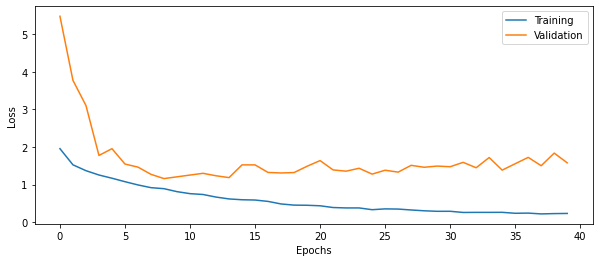

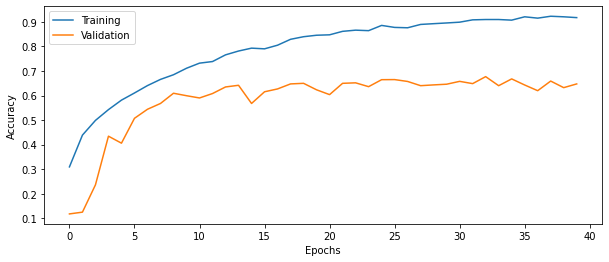

In [58]:
# Plot the history from the training run
plot_results(history5)

##  Part 16: Rotate the test images

How high is the test accuracy if we rotate the test images? In other words, how good is the CNN at generalizing to rotated images?

Rotate each test image 90 degrees, the cells are already finished.

Question 23: What is the test accuracy for rotated test images, compared to test images without rotation? Explain the difference in accuracy.

23. The accuracy for rotated iamges is about 23% as the CNN does not have rotation invariance, therefore, it is impossible for CNN to recognise 90 degree rotated images without training before.

In [30]:
def myrotate(images):

    images_rot = np.rot90(images, axes=(1,2))
    
    return images_rot

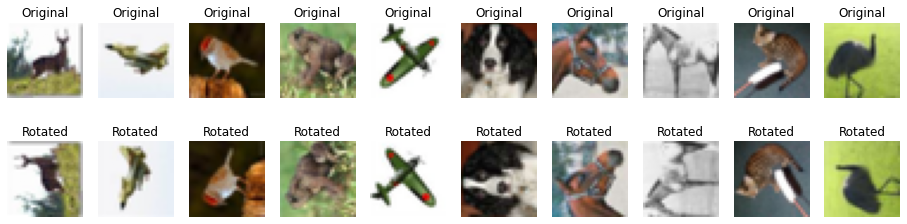

In [31]:
# Rotate the test images 90 degrees
Xtest_rotated = myrotate(Xtest)

# Look at some rotated images
plt.figure(figsize=(16,4))
for i in range(10):
    idx = np.random.randint(500)
    
    plt.subplot(2,10,i+1)
    plt.imshow(Xtest[idx]/2+0.5)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2,10,i+11)
    plt.imshow(Xtest_rotated[idx]/2+0.5)
    plt.title("Rotated")
    plt.axis('off')
plt.show()


In [32]:
# Evaluate the trained model on rotated test set
score = model5.evaluate(Xtest_rotated, Ytest, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 5.0429
Test accuracy: 0.2355


##  Part 17: Augmentation using Keras `ImageDataGenerator`

We can increase the number of training images through data augmentation (we now ignore that CIFAR10 actually has 60 000 training images). Image augmentation is about creating similar images, by performing operations such as rotation, scaling, elastic deformations and flipping of existing images. This will prevent overfitting, especially if all the training images are in a certain orientation.

We will perform the augmentation on the fly, using a built-in function in Keras, called `ImageDataGenerator`

See https://keras.io/preprocessing/image/ , the `flow` method should be used

Do *NOT* use use_multiprocessing=True here, as it can cause strange errors.

In [33]:
# Get all 60 000 training images again. ImageDataGenerator manages validation data on its own
(Xtrain, Ytrain), _ = cifar10.load_data()

# Reduce number of images to 10,000
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

# Change data type and rescale range
Xtrain = Xtrain.astype('float32')
Xtrain = Xtrain / 127.5 - 1

# Convert labels to hot encoding
Ytrain = to_categorical(Ytrain, 10)

In [41]:
# Set up a data generator with on-the-fly data augmentation, 20% validation split
# Use a rotation range of 30 degrees, horizontal and vertical flipping
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=30, horizontal_flip=True,vertical_flip=True,validation_split=0.2)

# Setup a flow for training data, assume that we can fit all images into CPU memory
training = datagen.flow(Xtrain, Ytrain, batch_size=80)

# Setup a flow for validation data, assume that we can fit all images into CPU memory
validation = datagen.flow(Xtrain, Ytrain, batch_size=80)

## Part 18: What about big data?

Question 24: How would you change the code for the image generator if you cannot fit all training images in CPU memory? What is the disadvantage of doing that change?

24. Use replace the flow by flow_from_directory. The drawback is training processsion might be longer.


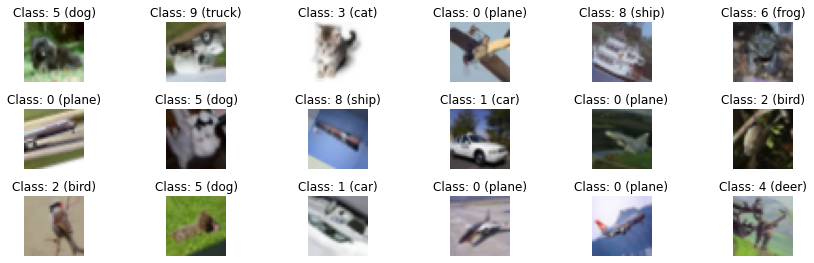

In [42]:
# Plot some augmented images
plot_datagen = datagen.flow(Xtrain, Ytrain, batch_size=1)

plt.figure(figsize=(12,4))
for i in range(18):
    (im, label) = plot_datagen.next()
    im = (im[0] + 1) * 127.5
    im = im.astype('int')
    label = np.flatnonzero(label)[0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

## Part 19: Train the CNN with images from the generator



See https://keras.io/api/models/model_training_apis/#fit-method for how to use model.fit with a generator instead of a fix dataset (numpy arrays)

To make the comparison fair to training without augmentation

    steps_per_epoch should be set to: len(Xtrain)*(1 - validation_split)/batch_size

    validation_steps should be set to: len(Xtrain)*validation_split/batch_size

Question 25: How quickly is the training accuracy increasing compared to without augmentation? Explain why there is a difference compared to without augmentation. What parameter is necessary to change to perform more training?

25. It becomes slower in increasing of training accuracy as the image feed in training is changing all the time, while the images is fixed in network without augmentation. In order to perform more training, the number of epoch should be changed to larger value or change batch size to larger number, which means train the CNN with more data to increasing generalization ability.

Question 26: What other types of image augmentation can be applied, compared to what we use here?

26. Set each sample mean to 0, set input data mean to 0, change the brightness of images, etc.

In [66]:
# Setup some training parameters
batch_size = 80
epochs = 100
n_conv_layers = 4
n_filters = 25
n_dense_layers = 1
n_nodes = 64
lr = 0.005
input_shape = Xtrain.shape

# Build model (your best config)
model6 = build_CNN(input_shape, n_conv_layers=n_conv_layers, n_filters=n_filters, n_dense_layers=n_dense_layers, n_nodes=n_nodes, use_dropout=True, learning_rate=lr)

validation_split=0.2

# Train the model using on the fly augmentation
history6 = model6.fit(training, 
                      steps_per_epoch=len(Xtrain)*(1 - validation_split)/batch_size, 
                      epochs=epochs,
                      validation_data = validation,
                      validation_steps = len(Xtrain)*validation_split/batch_size)

model6.summary()

Epoch 1/100
75/75 [==============================] - 6s 65ms/step - loss: 2.3578 - accuracy: 0.2103 - val_loss: 3.1920 - val_accuracy: 0.1562
Epoch 2/100
75/75 [==============================] - 5s 61ms/step - loss: 1.7733 - accuracy: 0.3379 - val_loss: 3.3586 - val_accuracy: 0.1349
Epoch 3/100
75/75 [==============================] - 5s 61ms/step - loss: 1.6249 - accuracy: 0.3942 - val_loss: 3.3504 - val_accuracy: 0.1521
Epoch 4/100
75/75 [==============================] - 5s 61ms/step - loss: 1.5514 - accuracy: 0.4285 - val_loss: 3.3358 - val_accuracy: 0.1986
Epoch 5/100
75/75 [==============================] - 5s 61ms/step - loss: 1.5325 - accuracy: 0.4307 - val_loss: 2.0331 - val_accuracy: 0.3799
Epoch 6/100
75/75 [==============================] - 5s 60ms/step - loss: 1.4862 - accuracy: 0.4511 - val_loss: 2.3474 - val_accuracy: 0.3113
Epoch 7/100
75/75 [==============================] - 5s 60ms/step - loss: 1.4424 - accuracy: 0.4700 - val_loss: 2.1271 - val_accuracy: 0.3413
Epoch 

In [67]:
# Check if there is still a big difference in accuracy for original and rotated test images

# Evaluate the trained model on original test set
score = model6.evaluate(Xtest, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Evaluate the trained model on rotated test set
score = model6.evaluate(Xtest_rotated, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 1.0871
Test accuracy: 0.6395
Test loss: 2.6001
Test accuracy: 0.2965


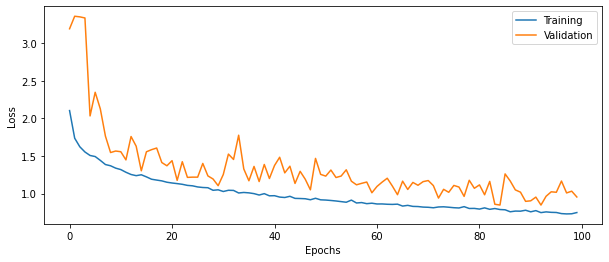

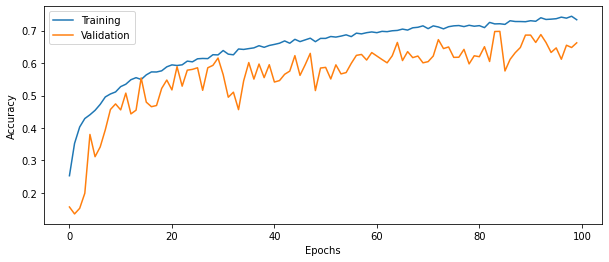

In [68]:
# Plot the history from the training run
plot_results(history6)

## Part 20: Plot misclassified images

Lets plot some images where the CNN performed badly, these cells are already finished.

In [ ]:
# Find misclassified images
y_pred = model6.predict_classes(Xtest)
y_correct = np.argmax(Ytest,axis=-1)

miss = np.flatnonzero(y_correct != y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


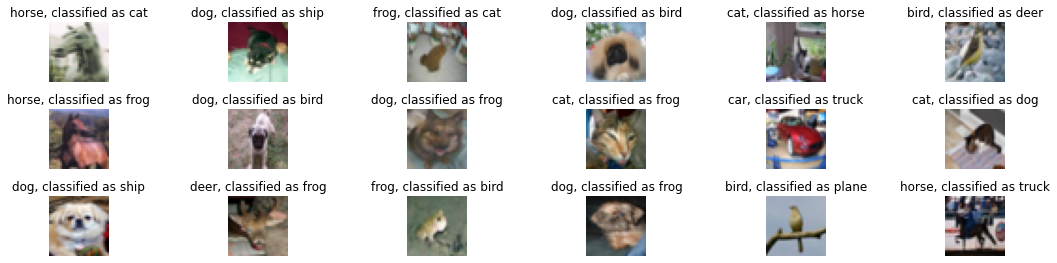

In [ ]:
# Plot a few of them
plt.figure(figsize=(15,4))
perm = np.random.permutation(miss)
for i in range(18):
    im = (Xtest[perm[i]] + 1) * 127.5
    im = im.astype('int')
    label_correct = y_correct[perm[i]]
    label_pred = y_pred[perm[i]]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.axis('off')
    plt.title("{}, classified as {}".format(classes[label_correct], classes[label_pred]))
plt.show()

##  Part 21: Testing on another size

Question 27: This CNN has been trained on 32 x 32 images, can it be applied to images of another size? If not, why is this the case?

27. No, it cannot classify the images with different size as the number of pixels does not match the the number of input for fully connected layer.

Question 28: Is it possible to design a CNN that can be trained on images of one size, and then applied to an image of any size? How?

28. Yes, there are two methods. First, resize the test image to the one that CNN can recognize. Second, use other network, such as SPP-Net,to replace fully connected network.

##  Part 22: Pre-trained 2D CNNs

There are many deep 2D CNNs that have been pre-trained using the large ImageNet database (several million images, 1000 classes). Import a pre-trained ResNet50 network from Keras applications. Show the network using `model.summary()`

Question 29: How many convolutional layers does ResNet50 have? 

29. There are 53 convolutional layer.

Question 30: How many trainable parameters does the ResNet50 network have? 

30. 25,583,592 trainable parameters.

Question 31: What is the size of the images that ResNet50 expects as input?

31. The input size is 224*224*3.

Question 32: Using the answer to question 30, explain why the second derivative is seldom used when training deep networks.

32. The hessian matrics will be the size of 25,583,592*25,583,592 which is super time-consuming to compute and need a large space to store it.

Apply the pre-trained CNN to 5 random color images that you download and copy to the cloud machine or your own computer. Are the predictions correct? How certain is the network of each image class?

33. The predicted result is correct and class is  quite specific, for example, the first image is train, but the network can recognise it as bullet train.

These pre-trained networks can be fine tuned to your specific data, and normally only the last layers need to be re-trained, but it will still be too time consuming to do in this laboration.

See https://keras.io/api/applications/ and https://keras.io/api/applications/resnet/#resnet50-function 

Useful functions

`image.load_img` in keras.preprocessing

`image.img_to_array` in keras.preprocessing

`ResNet50` in keras.applications.resnet50

`preprocess_input` in keras.applications.resnet50

`decode_predictions` in keras.applications.resnet50

`expand_dims` in numpy


In [ ]:
# change working directory
from google.colab import drive
drive.mount('/content/gdrive')
 
path = "/content/gdrive/My Drive/CNN"
os.chdir(path)

Mounted at /content/gdrive


In [ ]:
# Your code for using pre-trained ResNet 50 on 5 color images of your choice. 
# The preprocessing should transform the image to a size that is expected by the CNN.
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions  
from numpy import expand_dims

model = ResNet50(weights='imagenet')

image_path = ['train.jpeg','motorcycle2.jpeg','car.jpeg','bicycle.jpeg','car2.jpg']
target = ['train','motorcycle','car','bicycle','car']
pred_label = ['s' for i in range(5)]
counter = 0

for i in image_path:
  img = load_img(i, target_size=(224, 224))
  x = img_to_array(img)
  x = expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)
  pred_label[counter] = decode_predictions(preds, top=1)[0]
  counter+=1

print('The predict result:',pred_label)
print("The target:",target)


40960/35363 [==================================] - 0s 0us/step
The predict result: [[('n02917067', 'bullet_train', 0.9999999)], [('n03791053', 'motor_scooter', 0.7353431)], [('n02930766', 'cab', 0.5691058)], [('n03792782', 'mountain_bike', 0.8955173)], [('n03770679', 'minivan', 0.44418016)]]
The target: ['train', 'motorcycle', 'car', 'bicycle', 'car']


In [ ]:

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________